## Importing packages and datasets

In [7]:
#!pip install pandasql
#!pip install imblearn
#!pip install keras
#!pip install xgboost

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from itertools import chain
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.utils.multiclass import unique_labels
import xgboost as xgb

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,Activation
from keras.models import load_model

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

Morandi = ['#2D241F','#614E52','#7A6747','#A06A50','#ADAEB2','#69647B',
           '#E2CDBC','#A56C41','#B17A7D','#A68782',
          '#903B1C','#92ACD1','#D0C1C6','#D6D6D6','#511F1E']

major_apt = ['ATL','BOS','BWI','CLT','DCA','DEN','DFW','DTW','EWR','FLL','HNL','IAD',
             'IAH','JFK','LAS','LAX','LGA','MCO','MDW','MEM','MIA','MSP','ORD','PHL',
             'PHX','PDX','SAN','SEA','SFO','SLC','TPA','LGB','OAK','SNA']

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import warnings
warnings.simplefilter('ignore')

#from helper import *

Using TensorFlow backend.


In [2]:
#!pip install jupyter_contrib_nbextensions
#!jupyter contrib nbextension install --user
#!jupyter nbextensions_configurator enable --user
#!jupyter nbextension enable collapsible_headings/main #install collasible headings
#!jupyter nbextension enable toc2/main #install collasible headings

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if normalize:
        plt.savefig('./images/cm1.png',dpi=300)
    else: 
        plt.savefig('./images/cm2.png',dpi=300)
    return ax

In [57]:
def plot_roc(fpr, tpr,roc_auc):
    fig, ax = plt.subplots()
    plt.title('Receiver Operating Characteristic')
    ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return ax

In [2]:
datetime_cols = ['CRS_DEP_DT', 'DEP_DELAY_TD', 'CRS_ELAPSED_TD', 'DEP_DT',
                'CRS_ARR_DT','ARR_DELAY_TD', 'ARR_DT']

In [3]:
training = pd.read_csv('training.csv',index_col = 0,parse_dates=datetime_cols)

In [4]:
training.shape

(4880865, 43)

## Feature Engineering

### Find previous flights

In [7]:
trn_mg_all = pd.DataFrame(columns=['TAIL_NUM', 'DEP_DT', 'ORIGIN', 'DEST', 'ARR_DT'])

for i in range(1,53,13):
#    trn_mg_ori = training[(training['Week_no']>=i)&(training['Week_no']<i+13)&
#                          (training['ORIGIN'].isin(major_apt))][['TAIL_NUM','ORIGIN','DEP_DT']]
    trn_mg_ori = training[(training['Week_no']>=i)&(training['Week_no']<i+13)][['TAIL_NUM','ORIGIN','DEP_DT']]
#     trn_mg_dest = training[(training['Week_no']>=i)&(training['Week_no']<i+13)&
#                           (training['DEST'].isin(major_apt))][['TAIL_NUM','DEST','ARR_DT']]
    trn_mg_dest = training[(training['Week_no']>=i)&(training['Week_no']<i+13)][['TAIL_NUM','DEST','ARR_DT']]
    
    trn_mg = pd.merge(trn_mg_ori,trn_mg_dest,
                      left_on=['TAIL_NUM','ORIGIN'],
                      right_on=['TAIL_NUM','DEST'],how='inner')
    
    trn_mg_first = trn_mg[trn_mg['DEP_DT']>
                          trn_mg['ARR_DT']].sort_values(by=['TAIL_NUM','DEP_DT','ARR_DT'],
                                                        ascending=[True,True,False])
    
    trn_mg_first = trn_mg_first.groupby(['TAIL_NUM','DEP_DT']).first().reset_index()
    
    trn_mg_all = trn_mg_all.append(trn_mg_first)
    
    print(i)

1
14
27
40


In [8]:
trn_mg_all.reset_index(drop=True,inplace=True)

In [9]:
trn_mg_all['Turnaround_time'] = trn_mg_all['DEP_DT'] - trn_mg_all['ARR_DT']

In [10]:
trn_mg_all.head()

,TAIL_NUM,DEP_DT,ORIGIN,DEST,ARR_DT,Turnaround_time
0,215NV,2018-01-01 08:26:00,MEM,MEM,2018-01-01 07:48:00,00:38:00
1,215NV,2018-01-01 12:46:00,FLL,FLL,2018-01-01 11:44:00,01:02:00
2,215NV,2018-01-01 15:31:00,GSP,GSP,2018-01-01 14:51:00,00:40:00
3,215NV,2018-01-01 18:53:00,FLL,FLL,2018-01-01 17:32:00,01:21:00
4,215NV,2018-01-01 21:42:00,ORF,ORF,2018-01-01 20:58:00,00:44:00


#### Merged back to the training set

In [11]:
training_prev = pd.merge(training,trn_mg_all,
                         left_on=['TAIL_NUM','ORIGIN','DEP_DT'],
                         right_on=['TAIL_NUM','ORIGIN','DEP_DT'],
                         how='inner',
                         suffixes=('','_prev'))

In [12]:
training_prev = pd.merge(training_prev,
                         training_prev[['TAIL_NUM','DEST','ARR_DT','CRS_ARR_DT','DISTANCE','DEP_DELAY']],
                         left_on=['TAIL_NUM','ORIGIN','ARR_DT_prev'],
                         right_on=['TAIL_NUM','DEST','ARR_DT'],
                         how='inner',
                         suffixes=('','_prev'))

### Create dependent variables

In [13]:
bins = [float('-Inf'),15,45,float('Inf')]
training_prev['DEP_DELAY_CAT'] = pd.cut(training_prev['DEP_DELAY'],bins=bins,
                                       labels=[0, 1, 2])

In [14]:
training_prev['DEP_DELAY_CAT'].value_counts()

0    3913141
1     450291
2     413212
Name: DEP_DELAY_CAT, dtype: int64

In [15]:
def binarise(data):
    if data <= 15:
        return 0
    else:
        return 1
    
training_prev['DEP_DELAY_BI'] = training_prev['DEP_DELAY'].apply(binarise)

### Airport average delay in the last 6 hours

In [11]:
training_prev['Last2'] = training_prev['CRS_DEP_DT'] - timedelta(seconds=60*60*2)
training_prev['Last8'] = training_prev['CRS_DEP_DT'] - timedelta(seconds=60*60*8)
training_prev['Last14'] = training_prev['CRS_DEP_DT'] - timedelta(seconds=60*60*14)

In [12]:
apr_avg_delay = pd.DataFrame(columns=['ORIGIN', 'DEP_DT', 'OP_CARRIER_FL_NUM', 
                                      'OP_UNIQUE_CARRIER','AVG_DELAY6'])
for i in range(1,53,1):
    pre_mg1 = training_prev[(training_prev['Week_no']>=i)&
                           (training_prev['Week_no']<i+1)][['ORIGIN','Last2','Last8','DEP_DT',
                                                            'OP_CARRIER_FL_NUM',
                                                            'OP_UNIQUE_CARRIER']]
    
    pre_mg2 = training_prev[(training_prev['Week_no']>=i-1)&
                           (training_prev['Week_no']<i+1)][['ORIGIN','DEP_DT','DEP_DELAY']]
    
    avg_delay = pysqldf("""SELECT a.ORIGIN,
                                  a.DEP_DT,
                                  a.OP_CARRIER_FL_NUM,
                                  a.OP_UNIQUE_CARRIER,
                                  avg(a.DEP_DELAY) as AVG_DELAY6
                           FROM 
                              (SELECT *
                               FROM pre_mg1 a 
                                    INNER JOIN pre_mg2 b 
                                    on a.ORIGIN = b.ORIGIN
                                       and a.Last2 >= b.DEP_DT
                                       and a.Last8 <= b.DEP_DT) a
                            GROUP BY a.ORIGIN,a.DEP_DT,
                                     a.OP_CARRIER_FL_NUM,a.OP_UNIQUE_CARRIER
                            ;""")

    apr_avg_delay = apr_avg_delay.append(avg_delay)
    
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52


In [15]:
apr_avg_delay.to_csv('apr_avg_delay.csv')

In [16]:
apr_avg_delay = pd.read_csv('apr_avg_delay.csv',index_col=0)

In [17]:
# Merge back to the training_prev 
apr_avg_delay['DEP_DT'] = pd.to_datetime(apr_avg_delay['DEP_DT'])
training_prev = pd.merge(training_prev,apr_avg_delay,
                         left_on=['ORIGIN', 'DEP_DT', 
                                  'OP_CARRIER_FL_NUM','OP_UNIQUE_CARRIER'],
                         right_on=['ORIGIN', 'DEP_DT',
                                  'OP_CARRIER_FL_NUM','OP_UNIQUE_CARRIER'],
                         how='left',
                         suffixes=('','_day'))

In [18]:
# 32520 rows don't have avg_delay for the last 12 hours due to no flights in the airport 
training_prev[training_prev['AVG_DELAY6'].isnull()].shape

(287331, 54)

In [19]:
# fill the missing value with 0 since if it is missing, it normally means there is no flights
training_prev['AVG_DELAY6'] = training_prev['AVG_DELAY6'].fillna(0)

In [20]:
sum(training_prev['AVG_DELAY6'].isnull())

0

### Estimated turnaround time

In [22]:
training_prev['EST_TRN'] = training_prev['CRS_DEP_DT'] - training_prev['CRS_ARR_DT_prev']

### Future airport delay status from the LSTM model

In [24]:
base_ready = pd.read_csv('base_ready.csv',index_col=0)
base_ready = base_ready[['ORIGIN','CRS_DEP_DT','CRS_DEP_Hr','Prediction','DEP_CNT','ARR_CNT']]
base_ready.rename({'Prediction':'ARP_DELAY'},axis=1,inplace=True)

In [26]:
training_prev.loc[:,'CRS_DEP_Hr'] = training_prev.loc[:,'CRS_DEP_DT'].dt.hour
training_prev = pd.merge(training_prev,base_ready,
                         left_on=['ORIGIN','FL_DATE','CRS_DEP_Hr'],
                         right_on=['ORIGIN','CRS_DEP_DT','CRS_DEP_Hr'],
                         how='inner')

In [28]:
training_prev.shape

(3342691, 60)

In [29]:
training_prev.rename({'CRS_DEP_DT_x':'CRS_DEP_DT'},axis=1,inplace=True)
training_prev.drop(['CRS_DEP_Hr', 'CRS_DEP_DT_y'],axis=1,inplace=True)

In [30]:
training_prev.columns

Index(['FL_DATE', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN', 'DEST_AIRPORT_ID', 'DEST', 'DEP_DELAY',
       'ARR_DELAY', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME',
       'DISTANCE', 'CRS_DEP_DT', 'DEP_DELAY_TD', 'CRS_ELAPSED_TD', 'DEP_DT',
       'Weekday', 'Month', 'Day', 'Week_no', 'CRS_ARR_DT', 'ARR_DELAY_TD',
       'ARR_DT', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'uvIndex', 'visibility', 'winddir16Point', 'winddirDegree',
       'windspeedKmph', 'weatherDesc_new', 'Wide', 'Year', 'DEST_prev',
       'ARR_DT_prev', 'Turnaround_time', 'DEST_prev', 'ARR_DT_prev',
       'CRS_ARR_DT_prev', 'DISTANCE_prev', 'DEP_DELAY_prev', 'DEP_DELAY_CAT',
       'DEP_DELAY_BI', 'AVG_DELAY6', 'EST_TRN', 'ARP_DELAY', 'DEP_CNT',
       'ARR_CNT'],
      dtype='object')

### OD-pair delay status

In [7]:
def get_od_name(x):
    if x['ORIGIN'] > x['DEST']:
        return x['DEST'] + '-' + x['ORIGIN']
    elif x['ORIGIN'] < x['DEST']:
        return x['ORIGIN'] + '-' + x['DEST']

training_prev['OD'] = training_prev[['ORIGIN','DEST']].apply(get_od_name,axis=1)

In [8]:
training_prev['Last2'] = training_prev['CRS_DEP_DT'] - timedelta(seconds=60*60*2)
training_prev['Last8'] = training_prev['CRS_DEP_DT'] - timedelta(seconds=60*60*8)

In [9]:
od_delay_total = pd.DataFrame(columns=['OD', 'ORIGIN', 'DEP_DT', 'OP_CARRIER_FL_NUM',
                                       'OP_UNIQUE_CARRIER','OD_DELAY6'])
for i in range(1,53,4):
    pre_mg1 = training_prev[(training_prev['Week_no']>=i)&
                           (training_prev['Week_no']<i+4)][['OD','ORIGIN','Last2','Last8','DEP_DT',
                                                            'OP_CARRIER_FL_NUM',
                                                            'OP_UNIQUE_CARRIER']]
    
    pre_mg2 = training_prev[(training_prev['Week_no']>=i-1)&
                           (training_prev['Week_no']<i+4)][['OD','ORIGIN','DEP_DT','DEP_DELAY']]
    
    od_delay = pysqldf("""SELECT a.OD,
                                  a.ORIGIN,
                                  a.DEP_DT,
                                  a.OP_CARRIER_FL_NUM,
                                  a.OP_UNIQUE_CARRIER,
                                  avg(a.DEP_DELAY) as OD_DELAY6
                           FROM 
                              (SELECT a.*,
                                      b.DEP_DELAY
                               FROM pre_mg1 a 
                                    INNER JOIN pre_mg2 b 
                                    on a.OD = b.OD
                                       and a.Last2 >= b.DEP_DT
                                       and a.Last8 <= b.DEP_DT) a
                           GROUP BY a.OD,a.ORIGIN,a.DEP_DT,
                                    a.OP_CARRIER_FL_NUM,a.OP_UNIQUE_CARRIER
                            ;""")

    od_delay_total = od_delay_total.append(od_delay)

In [10]:
od_delay_total['DEP_DT'] = pd.to_datetime(od_delay_total['DEP_DT'])
training_prev = pd.merge(training_prev,od_delay_total,
                         left_on=['OD','ORIGIN', 'DEP_DT', 
                                  'OP_CARRIER_FL_NUM','OP_UNIQUE_CARRIER'],
                         right_on=['OD','ORIGIN', 'DEP_DT',
                                  'OP_CARRIER_FL_NUM','OP_UNIQUE_CARRIER'],
                         how='left')

In [11]:
print('the number of missing values: ' + str(sum(training_prev['OD_DELAY6'].isnull()))) #due to no flights in the OD during the time

the number of missing values: 779310


In [12]:
# fill the missing value with 0 since if it is missing, it normally means there is no flights
training_prev['OD_DELAY6'] = training_prev['OD_DELAY6'].fillna(0)

In [13]:
sum(training_prev['OD_DELAY6'].isnull())

0

### One-hot encoding for airlines and weather description

In [9]:
# get one-hot encoding columns for airlines
op_dum = pd.get_dummies(training_prev['OP_UNIQUE_CARRIER'],drop_first=True)
training_prev = pd.concat([training_prev,op_dum],axis=1)

In [10]:
# get one-hot encoding columns for weather descriptions
training_prev['MHFRain'] = (training_prev['weatherDesc_new'] == 'Moderate or heavy freezing rain').apply(int)
training_prev['IcePellets'] = (training_prev['weatherDesc_new'] == 'Ice pellets').apply(int)
training_prev['Blizzard'] = (training_prev['weatherDesc_new'] == 'Blizzard').apply(int)
training_prev['HeavyRain'] = (training_prev['weatherDesc_new'] == 'Heavy rain').apply(int)
training_prev['MHSleet'] = (training_prev['weatherDesc_new'] == 'Moderate or heavy sleet').apply(int)
training_prev['HeavySnow'] = (training_prev['weatherDesc_new'] == 'Heavy snow').apply(int)

### Estimated minimum turnaround time

In [12]:
min5_trn = training_prev.groupby(['OP_UNIQUE_CARRIER','OP_CARRIER_FL_NUM','ORIGIN','DEST'])['Turnaround_time'].quantile(.05)
min5_trn = pd.DataFrame(min5_trn).reset_index()
min5_trn['Turnaround_time'] = min5_trn['Turnaround_time'].dt.seconds/60
min5_trn.rename({'Turnaround_time':'MIN5_TRN'},axis=1,inplace=True)

In [13]:
training_prev = pd.merge(training_prev,min5_trn,
                         left_on=['OP_UNIQUE_CARRIER','OP_CARRIER_FL_NUM','ORIGIN','DEST'],
                         right_on=['OP_UNIQUE_CARRIER','OP_CARRIER_FL_NUM','ORIGIN','DEST'],
                         how = 'left')

### Turnaround buffer time (EST_TRN - MIN_TRN)

In [14]:
training_prev['Buff_TRN'] = (training_prev['EST_TRN'].dt.seconds/60 
                             - training_prev['MIN5_TRN']).apply(lambda x: 0 if x <= 0 else x)

### Export training_prev.csv

In [16]:
training_prev.to_csv('training_prev.csv')

In [3]:
datetime_cols = ['CRS_DEP_DT','DEP_DELAY_TD','CRS_ELAPSED_TD','DEP_DT',
                 'CRS_ARR_DT','ARR_DELAY_TD','ARR_DT','ARR_DT_prev']

In [4]:
training_prev = pd.read_csv('training_prev.csv',index_col = 0, parse_dates = datetime_cols)

In [5]:
TD_cols = ['DEP_DELAY_TD', 'CRS_ELAPSED_TD',
           'ARR_DELAY_TD','Turnaround_time','EST_TRN']
for i in TD_cols:
    training_prev.loc[:,i] = pd.to_timedelta(training_prev.loc[:,i])

In [6]:
training_prev.shape

(3342691, 85)

In [7]:
training_prev.columns

Index(['FL_DATE', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN', 'DEST_AIRPORT_ID', 'DEST', 'DEP_DELAY',
       'ARR_DELAY', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME',
       'DISTANCE', 'CRS_DEP_DT', 'DEP_DELAY_TD', 'CRS_ELAPSED_TD', 'DEP_DT',
       'Weekday', 'Month', 'Day', 'Week_no', 'CRS_ARR_DT', 'ARR_DELAY_TD',
       'ARR_DT', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'uvIndex', 'visibility', 'winddir16Point', 'winddirDegree',
       'windspeedKmph', 'weatherDesc_new', 'Wide', 'Year', 'DEST_prev',
       'ARR_DT_prev', 'Turnaround_time', 'CRS_ARR_DT_prev', 'DISTANCE_prev',
       'DEP_DELAY_prev', 'DEP_DELAY_CAT', 'DEP_DELAY_BI', 'AVG_DELAY6',
       'EST_TRN', 'ARP_DELAY', 'DEP_CNT', 'ARR_CNT', 'OD', 'Last2', 'Last8',
       'OD_DELAY6', 'AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'G4', 'HA', 'MQ', 'NK',
       'OH', 'OO', 'UA',

## Create a baseline model

### Build input dataset

In [8]:
features = ['CRS_ELAPSED_TD','DISTANCE','CRS_DEP_DT','CRS_ARR_DT','DEP_DELAY_prev','AVG_DELAY6','ARP_DELAY','Month', 'EST_TRN', 'WN', 
            'OD_DELAY6','MIN5_TRN','Buff_TRN','DewPointC','windspeedKmph', 'cloudcover','humidity', 'pressure','tempC','Weekday']
features1 = ['CRS_ELAPSED_TD','CRS_DEP_DT','CRS_ARR_DT','DewPointC','DEP_DELAY_prev','AVG_DELAY6','ARP_DELAY','Month',
             'EST_TRN','OD_DELAY6','MIN5_TRN','Buff_TRN','DISTANCE','cloudcover']
features2 = ['CRS_ELAPSED_TD','CRS_DEP_DT','CRS_ARR_DT','DewPointC','DEP_DELAY_prev','AVG_DELAY6','Month',
             'EST_TRN','OD_DELAY6','MIN5_TRN','Buff_TRN','DISTANCE','cloudcover']
training_input = training_prev[features2]
training_input.loc[:,'CRS_ELAPSED_TD'] = training_input.loc[:,'CRS_ELAPSED_TD'].dt.seconds/60
training_input.loc[:,'EST_TRN'] = training_input.loc[:,'EST_TRN'].dt.seconds/60
training_input.loc[:,'CRS_DEP_DT'] = training_input.loc[:,'CRS_DEP_DT'].dt.hour
training_input.loc[:,'CRS_ARR_DT'] = training_input.loc[:,'CRS_ARR_DT'].dt.hour
#training_input.loc[:,'DEP_DELAY_TD_prev'] = training_input.loc[:,'DEP_DELAY_TD_prev'].dt.seconds/60

In [9]:
dummy_y = np_utils.to_categorical(training_prev['DEP_DELAY_CAT'])

# consistent with the LSTM model, using August and September as testing data
train_ix = training_input[~training_input['Month'].isin([8,9])].index
test_ix = training_input[training_input['Month'].isin([8,9])].index

X_train = training_input.iloc[train_ix,:]
y_train = training_prev['DEP_DELAY_BI'][train_ix]
#y_train = dummy_y[train_ix]

X_test = training_input.iloc[test_ix,:]
y_test = training_prev['DEP_DELAY_BI'][test_ix]
#y_test = dummy_y[test_ix]

In [50]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(training_input,
#                                                    training_prev['DEP_DELAY_CAT'],
#                                                    test_size=0.33, random_state=42)

### Under-sampling/over-sampling

In [30]:
cat_cnt = training_prev['DEP_DELAY_BI'].value_counts()

In [31]:
cat_cnt

0    2714683
1     628008
Name: DEP_DELAY_BI, dtype: int64

In [32]:
from imblearn.under_sampling import RandomUnderSampler
#rus = RandomUnderSampler(sampling_strategy={0:cat_cnt[1],
#                                            1:cat_cnt[1],
#                                            2:cat_cnt[2]},random_state=42)

rus = RandomUnderSampler(sampling_strategy={0:cat_cnt[1],
                                            1:cat_cnt[1]},random_state=42)

X_resampled, y_resampled = rus.fit_resample(training_input, training_prev['DEP_DELAY_BI'])

In [199]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy={0:cat_cnt[0],
                                            1:cat_cnt[0],
                                            2:cat_cnt[0]},random_state=42)

#rus = RandomUnderSampler(sampling_strategy={0:y_train.value_counts()[1],
#                                            1:y_train.value_counts()[1]},random_state=42)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

### Standardization

In [69]:
def stdize(X_train,X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

### Train the model

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

#clf = RandomForestClassifier(n_estimators=100,random_state=42,verbose=1,n_jobs=-1)

#clf = GradientBoostingClassifier(n_estimators=100,learning_rate=0.1,
#                                 random_state=42,verbose=1,validation_fraction=0.1,
#                                 n_iter_no_change = 10)

clf = XGBClassifier(verbosity=1)

#clf = MLPClassifier(verbose=2,hidden_layer_sizes=(128,64,32,16,),random_state=42,max_iter=5,early_stopping=True)

clf.fit(X_resampled, y_resampled)
#clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

### Make prediction

In [21]:
#X_test = scaler.transform(X_test)
y_pred = clf.predict(X_test.values)
#y_pred = np.array(list(map(lambda x: 0 if x<=0.5 else 1,y_pred.flatten())))

In [24]:
pd.DataFrame({'column':training_input.columns,
              'importance':clf.feature_importances_}).sort_values(by='importance',ascending=False)

,column,importance
4,DEP_DELAY_prev,0.319401
8,EST_TRN,0.130303
19,Buff_TRN,0.118637
6,ARP_DELAY,0.116963
1,CRS_DEP_DT,0.102159
17,OD_DELAY6,0.086461
5,AVG_DELAY6,0.028444
9,B6,0.020572
2,CRS_ARR_DT,0.016591
3,DewPointC,0.012607


In [25]:
confusion_matrix(y_test, y_pred, labels=[0,1])

array([[468038,  96548],
       [ 41648,  93747]])

Confusion matrix, without normalization
[[468038  96548]
 [ 41648  93747]]


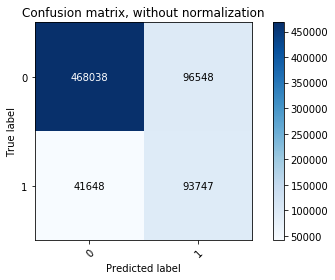

In [26]:
plot_confusion_matrix(y_test,y_pred,classes=[0,1])

Normalized confusion matrix
[[0.82899328 0.17100672]
 [0.30760368 0.69239632]]


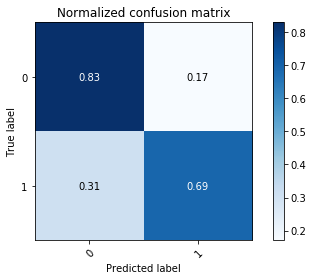

In [27]:
plot_confusion_matrix(y_test,y_pred,classes=[0,1],normalize=True)

In [28]:
from sklearn.metrics import accuracy_score

print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('F1: ' + str(f1_score(y_test, y_pred)))

Accuracy: 0.8025717840912825
Recall: 0.6923963218730381
Precision: 0.49264037415591583
F1: 0.5756823973717338


In [77]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred)

0.20277407529632946

In [159]:
maes = abs(np.array(y_pred) - np.array(y_test))
print(str(round(sum(maes < 5)/len(maes)*100)) + '% of times the error is less than 10 minutes')

100.0% of times the error is less than 10 minutes


### Linear Regression Result

In [90]:
import statsmodels.api as sm

X = training_input
y = training_prev['DEP_DELAY']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X,columns=training_input.columns)
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              DEP_DELAY   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                 4.064e+04
Date:                Wed, 05 Jun 2019   Prob (F-statistic):               0.00
Time:                        18:50:40   Log-Likelihood:            -1.6970e+07
No. Observations:             3342691   AIC:                         3.394e+07
Df Residuals:                 3342670   BIC:                         3.394e+07
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             10.7528      0.021    506.972      0.000      10.711      10.794
CRS_ELAPSED_TD     0.2227      0.022     10.324      0.000       0.180       0.265
CRS_DEP_DT         1.6841      0.028     60.243      0.000       1.629       1.739
CRS_ARR_DT         0.8808      0.027     33.135      0.000       0.829       0.933
DewPointC          0.2377      0.028      8.478      0.000       0.183       0.293
DEP_DELAY_prev    11.5875      0.022    529.356      0.000      11.545      11.630
AVG_DELAY6        -0.5723      0.023    -24.688      0.000      -0.618      -0.527
ARP_DELAY         10.9420      0.023    484.707      0.000      10.898      10.986
Month              0.2864      0.028     10.259      0.000       0.232       0.341
EST_TRN          -23.1122      0.407    -56.720      0.000     -23.911     -22.314
B6                 0.5943      0.021     27.778      0.000       0.552       0.636
F9                 0.9341      0.021     43.897      0.000       0.892       0.976
MHFRain            0.2804      0.021     13.208      0.000       0.239       0.322
IcePellets         0.1757      0.021      8.284      0.000       0.134       0.217
Blizzard           0.3126      0.021     14.726      0.000       0.271       0.354
HeavyRain          0.1981      0.021      9.331      0.000       0.156       0.240
MHSleet            0.0891      0.021      4.200      0.000       0.048       0.131
HeavySnow          0.6085      0.021     28.609      0.000       0.567       0.650
OD_DELAY6          1.0328      0.022     46.324      0.000       0.989       1.076
MIN5_TRN           7.6005      0.151     50.310      0.000       7.304       7.897
Buff_TRN          26.3987      0.371     71.178      0.000      25.672      27.126
==============================================================================
Omnibus:                  4939916.677   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       4384044737.703
Skew:                           8.767   Prob(JB):                         0.00
Kurtosis:                     179.548   Cond. No.                         42.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Build a simple keras ANN model

In [9]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [10]:
from keras import optimizers
def train_ann(X_train,y_train,params,class_weight=False):
    
    # Get the hyper-parameters
    epochs = params['epochs']
    validation_split = params['validation_split']
    batch_size = params['batch_size']
    if class_weight == True:     
        class_weight = params['class_weight']
    else:
        class_weight = None
    n_features = X_train.shape[1]
    
    # create model
    
    model = Sequential()
    model.add(Dense(200, input_dim=n_features, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    #model.add(Dense(64, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    #model.add(Dense(32, activation='relu'))
    #model.add(Dropout(0.5))
    #model.add(Dense(10, activation='relu'))
    #model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    #model.add(Dense(3, activation='softmax'))
    
    
    """
    model = Sequential()
    model.add(Dense(200, input_dim=n_features))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    #model.add(Dense(3, activation='softmax'))
    """
    
    #model.summary()
    
    opt = optimizers.Adadelta()
    #opt = optimizers.Adam()
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    #model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    # Fit model
    history = model.fit(X_train, y_train
                        ,batch_size=batch_size
                        ,epochs=epochs
                        ,verbose=1
                        ,validation_split=validation_split
                        ,class_weight = class_weight
                       )
    
    return model, history

In [60]:
y_integers = np.argmax(dummy_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

In [42]:
class_weights = compute_class_weight('balanced', np.array([0,1]), training_prev['DEP_DELAY_BI'])
d_class_weights = dict(enumerate(class_weights))

In [78]:
ann_param = {'batch_size':128,
             'epochs':2,
             'validation_split':0,
             'class_weight':d_class_weights}

In [79]:
#model, history = train_ann(X_resampled,y_resampled,ann_param)
model, history = train_ann(X_train,y_train,ann_param)

Epoch 1/2
2642710/2642710 [==============================] - 67s 25us/step - loss: 0.5144 - acc: 0.8079
Epoch 2/2
2642710/2642710 [==============================] - 64s 24us/step - loss: 0.5002 - acc: 0.8122


In [80]:
y_pred = model.predict(X_test, verbose=1)
#y_pred = np.array(list(map(lambda x: 0 if x<=0.5 else 1,y_pred.flatten())))

699981/699981 [==============================] - 21s 30us/step


In [82]:
y_pred = [np.argmax(i) for i in y_pred]

In [34]:
y_test_c = [np.argmax(i) for i in y_test]

In [85]:
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('Recall: ' + str(recall_score(y_test, y_pred,average='macro')))
print('Precision: ' + str(precision_score(y_test, y_pred,average='macro')))
print('F1: ' + str(f1_score(y_test, y_pred,average='macro')))

Accuracy: 0.8065733212758632
Recall: 0.5
Precision: 0.4032866606379316
F1: 0.4464658653910785


In [ ]:
plot_confusion_matrix(y_test,y_pred,classes=[0,1],normalize=True)

Confusion matrix, without normalization
[[417579 103741  43266]
 [ 21412  33988  11708]
 [ 11626  14802  41859]]


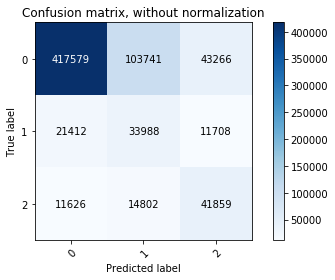

In [37]:
plot_confusion_matrix(y_test_c,y_pred,classes=[0,1,2],normalize=False)

In [179]:
# save the keras model
model.save('./keras_model/#A8.h5')

## Build a Cross Validation model

In [11]:
def kfold_validation(x_train,y_train,cats=3,std=False,class_weight=False):

    cross_val_f1_score_lst = [];cross_val_accuracy_lst = [];train_accuracy_lst = [];cross_val_recall_lst = []
    cross_val_precision_lst = [];validation_preds_lst = [];target_val_lst = [];cross_val_roc_lst = [];prob_lst = []

    train_end_months = np.array([2,3,4,5,6,7,8])
    for train_month in train_end_months:
        train_ix = x_train[(x_train['Month']<=train_month)
                           &(x_train['Month']>=train_month-1)
                          ].index
        val_ix = x_train[(x_train['Month']>train_month)&(x_train['Month']<=train_month+1)].index
        # keeping validation set apart and undersampling in each iteration 
        train, validation = x_train.iloc[train_ix], x_train.iloc[val_ix]
        target_train, target_val = y_train.iloc[train_ix], y_train.iloc[val_ix]
        if cats == 3:
            target_train_3 = np_utils.to_categorical(target_train)
            target_val = np_utils.to_categorical(target_val)
        print(train.shape,validation.shape)
        
        #cat_cnt = target_train.value_counts()
        #rus = RandomUnderSampler(sampling_strategy={0:cat_cnt[1],
        #                                           1:cat_cnt[1],
        #                                           2:cat_cnt[2]},random_state=42)
        #rus = RandomUnderSampler(sampling_strategy={0:cat_cnt[1],
        #                                           1:cat_cnt[1]},random_state=42)
        #sm = SMOTE(random_state=42)
        #X_train_res, y_train_res = sm.fit_resample(train, target_train)
        #X_train_res, y_train_res = rus.fit_resample(train, target_train_3)
        #X_train_res, y_train_res = rus.fit_resample(train, target_train)

        if std == True: #standardize the training and testing set
            X_train_res, validation = stdize(X_train_res,validation)
        
        # training the model
        #model,history = train_ann(train,target_train_3,ann_param,class_weight=class_weight)
        model,history = train_ann(train,target_train,ann_param,class_weight=class_weight)
        #model,history = train_ann(X_train_res,y_train_res,ann_param,class_weight=class_weight)
        
        # testing on 1 fold of validation set
        validation_preds = model.predict(validation, verbose=1)
        #prob = model.predict_proba(validation)
        #train_preds = model.predict(train, verbose=1)
        if cats == 3:
            validation_preds = [np.argmax(i) for i in validation_preds]
            target_val = [np.argmax(i) for i in target_val]
            train_preds = [np.argmax(i) for i in train_preds]
            target_train = [np.argmax(i) for i in target_train]
        elif cats == 2:
            validation_preds = np.array(list(map(lambda x: 0 if x<=0.5 else 1,validation_preds.flatten())))
            #train_preds = np.array(list(map(lambda x: 0 if x<=0.5 else 1,train_preds.flatten())))

        cross_val_recall_lst.append(recall_score(target_val, validation_preds,average='macro'))
        cross_val_accuracy_lst.append(accuracy_score(target_val, validation_preds))
        #train_accuracy_lst.append(accuracy_score(target_train, train_preds))
        cross_val_precision_lst.append(precision_score(target_val, validation_preds,average='macro'))
        cross_val_f1_score_lst.append(f1_score(target_val, validation_preds,average='macro'))
        validation_preds_lst.append(validation_preds)
        #prob_lst.append(prob)
        target_val_lst.append(target_val)
        cross_val_roc_lst.append(roc_auc_score(target_val, validation_preds))
        
    print ('Cross validated accuracy: {}'.format(np.mean(cross_val_accuracy_lst)))
    #print ('Training accuracy: {}'.format(np.mean(train_accuracy_lst)))
    print ('Cross validated recall score: {}'.format(np.mean(cross_val_recall_lst)))
    print ('Cross validated precision score: {}'.format(np.mean(cross_val_precision_lst)))
    print ('Cross validated f1_score: {}'.format(np.mean(cross_val_f1_score_lst)))
    print ('Cross validated roc_auc: {}'.format(np.mean(cross_val_roc_lst)))
    
    validation_preds = list(chain.from_iterable(validation_preds_lst))
    target_val = list(chain.from_iterable(target_val_lst))
    plot_confusion_matrix(target_val,validation_preds,classes=[0,1,2],normalize=True) #plot confusion matrix
    plot_confusion_matrix(target_val,validation_preds,classes=[0,1,2],normalize=False)
    
    #prob = list(chain.from_iterable(prob_lst))
    #fpr, tpr, threshold = roc_curve(target_val, prob)
    #roc_auc = auc(fpr, tpr)
    
    return model,validation_preds_lst,target_val_lst

In [12]:
def get_cw(data):
    y_integers = np.argmax(data, axis=1)
    class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
    d_class_weights = dict(enumerate(class_weights))
    return d_class_weights

In [17]:
# for three categories
d_class_weights = get_cw(dummy_y)

In [12]:
class_weights = compute_class_weight('balanced', np.array([0,1]), training_prev['DEP_DELAY_BI'])
d_class_weights = dict(enumerate(class_weights))

In [13]:
ann_param = { 
              'batch_size':128
             ,'epochs':2
             ,'validation_split':0
             ,'class_weight':d_class_weights
            }

In [244]:
# load the model
model = load_model('./keras_model/#A8.h5')

(691142, 13) (366282, 13)
Epoch 1/2
691142/691142 [==============================] - 17s 25us/step - loss: 1.7431 - acc: 0.7576
Epoch 2/2
366282/366282 [==============================] - 8s 22us/step
(704186, 13) (376050, 13)
Epoch 1/2
704186/704186 [==============================] - 18s 26us/step - loss: 2.8576 - acc: 0.7395
Epoch 2/2
376050/376050 [==============================] - 9s 23us/step
(742332, 13) (401094, 13)
Epoch 1/2
742332/742332 [==============================] - 19s 26us/step - loss: 1.9073 - acc: 0.7666
Epoch 2/2
401094/401094 [==============================] - 9s 23us/step
(777144, 13) (404744, 13)
Epoch 1/2
777144/777144 [==============================] - 20s 26us/step - loss: 2.2067 - acc: 0.7426
Epoch 2/2
404744/404744 [==============================] - 10s 24us/step
(805838, 13) (403398, 13)
Epoch 1/2
805838/805838 [==============================] - 21s 26us/step - loss: 1.1193 - acc: 0.4028
Epoch 2/2
403398/403398 [==============================] - 10s 25us/ste

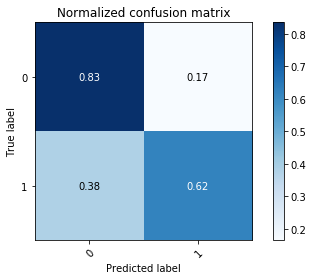

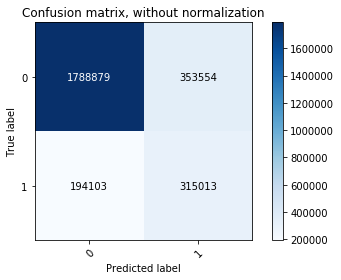

In [30]:
model,validation_preds_lst,target_val_lst = kfold_validation(training_input,
                                                             training_prev['DEP_DELAY_BI'],
                                                             cats=2,std=False,class_weight=True)

In [26]:
# save the keras model
model.save('./keras_model/#A18.h5')

## Predict on the testing set

In [17]:
testing = pd.read_csv('./test/testing.csv',index_col=0)
lstm_test_pred = pd.read_csv('./test/lstm_test_pred.csv',index_col=0)

In [18]:
testing['CRS_DEP_DT'] = pd.to_datetime(testing['CRS_DEP_DT'])
lstm_test_pred = lstm_test_pred[['ORIGIN','CRS_DEP_DT','CRS_DEP_Hr','Prediction']]
testing.loc[:,'CRS_DEP_Hr'] = testing.loc[:,'CRS_DEP_DT'].dt.hour
testing = pd.merge(testing,lstm_test_pred,
                   left_on=['ORIGIN','FL_DATE','CRS_DEP_Hr'],
                   right_on=['ORIGIN','CRS_DEP_DT','CRS_DEP_Hr'],
                   how='inner')

In [19]:
testing.rename({'Prediction':'ARP_DELAY'},axis=1,inplace=True)
testing.rename({'CRS_DEP_DT_x':'CRS_DEP_DT'},axis=1,inplace=True)

In [21]:
features1 = ['CRS_ELAPSED_TD','CRS_DEP_DT','CRS_ARR_DT','DewPointC','DEP_DELAY_prev','AVG_DELAY6','ARP_DELAY','Month',
             'EST_TRN','OD_DELAY6','MIN5_TRN','Buff_TRN','DISTANCE','cloudcover']
features2 = ['CRS_ELAPSED_TD','CRS_DEP_DT','CRS_ARR_DT','DewPointC','DEP_DELAY_prev','AVG_DELAY6','Month',
             'EST_TRN','OD_DELAY6','MIN5_TRN','Buff_TRN','DISTANCE','cloudcover']
testing_input = testing[features2]

TD_cols = ['CRS_ELAPSED_TD','EST_TRN']
for i in TD_cols:
    testing_input.loc[:,i] = pd.to_timedelta(testing_input.loc[:,i])
    
testing_input.loc[:,'CRS_ELAPSED_TD'] = testing_input.loc[:,'CRS_ELAPSED_TD'].dt.seconds/60
testing_input.loc[:,'EST_TRN'] = testing_input.loc[:,'EST_TRN'].dt.seconds/60
testing_input.loc[:,'CRS_DEP_DT'] = testing_input.loc[:,'CRS_DEP_DT'].dt.hour
testing_input['CRS_ARR_DT'] = pd.to_datetime(testing_input['CRS_ARR_DT'])
testing_input.loc[:,'CRS_ARR_DT'] = testing_input.loc[:,'CRS_ARR_DT'].dt.hour

### Fit a baseline model on testing set

In [12]:
features1 = ['CRS_ELAPSED_TD','CRS_DEP_DT','CRS_ARR_DT','DewPointC','DEP_DELAY_prev','AVG_DELAY6','ARP_DELAY','Month',
             'EST_TRN','OD_DELAY6','MIN5_TRN','Buff_TRN','DISTANCE','cloudcover']
training_input = training_prev[features1]
training_input.loc[:,'CRS_ELAPSED_TD'] = training_input.loc[:,'CRS_ELAPSED_TD'].dt.seconds/60
training_input.loc[:,'EST_TRN'] = training_input.loc[:,'EST_TRN'].dt.seconds/60
training_input.loc[:,'CRS_DEP_DT'] = training_input.loc[:,'CRS_DEP_DT'].dt.hour
training_input.loc[:,'CRS_ARR_DT'] = training_input.loc[:,'CRS_ARR_DT'].dt.hour

In [13]:
from imblearn.under_sampling import RandomUnderSampler
cat_cnt = training_prev['DEP_DELAY_BI'].value_counts()

rus = RandomUnderSampler(sampling_strategy={0:cat_cnt[1],
                                            1:cat_cnt[1]},random_state=42)

X_resampled, y_resampled = rus.fit_resample(training_input, training_prev['DEP_DELAY_BI'])

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
#clf = DecisionTreeClassifier(random_state=42)
clf = RandomForestClassifier(n_estimators=100,random_state=42,verbose=1,n_jobs=-1)
clf.fit(X_resampled, y_resampled)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=1, warm_start=False)

In [15]:
y_pred_base = clf.predict(testing_input)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   13.4s finished


In [16]:
print('Accuracy: ' + str(accuracy_score(y_pred_base,testing['DEP_DELAY_BI'])))
print('Recall: '+ str(recall_score(y_pred_base,testing['DEP_DELAY_BI'],average='macro')))
print('Precision'+ str(precision_score(y_pred_base,testing['DEP_DELAY_BI'],average='macro')))
print('F1 ' + str(f1_score(y_pred_base,testing['DEP_DELAY_BI'],average='macro')))

Accuracy: 0.8308236987239175
Recall: 0.7096209354108982
Precision0.7565016535362504
F1 0.7276972806778036


Confusion matrix, without normalization
[[868246 131919]
 [ 71212 129329]]


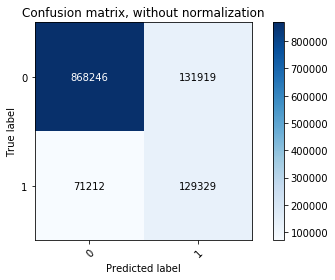

In [17]:
plot_confusion_matrix(testing['DEP_DELAY_BI'],y_pred_base,[0,1])

Normalized confusion matrix
[[0.86810276 0.13189724]
 [0.35509946 0.64490054]]


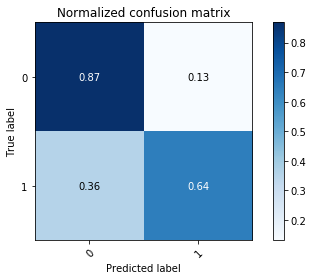

In [18]:
plot_confusion_matrix(testing['DEP_DELAY_BI'],y_pred_base,[0,1],normalize=True)

### Fit MLP on testing set

In [31]:
y_pred_mlp = model.predict(testing_input,verbose=1)
y_pred_mlp = np.array(list(map(lambda x: 0 if x<=0.5 else 1,y_pred_mlp.flatten())))

1200706/1200706 [==============================] - 30s 25us/step


In [32]:
print('Accuracy: ' + str(accuracy_score(y_pred_mlp,testing['DEP_DELAY_BI'])))
print('Recall: '+ str(recall_score(y_pred_mlp,testing['DEP_DELAY_BI'],average='macro')))
print('Precision'+ str(precision_score(y_pred_mlp,testing['DEP_DELAY_BI'],average='macro')))
print('F1 ' + str(f1_score(y_pred_mlp,testing['DEP_DELAY_BI'],average='macro')))

Accuracy: 0.8088874378907076
Recall: 0.6814080472038061
Precision0.7294527187143053
F1 0.6985109414284105


Confusion matrix, without normalization
[[848871 151294]
 [ 78176 122365]]


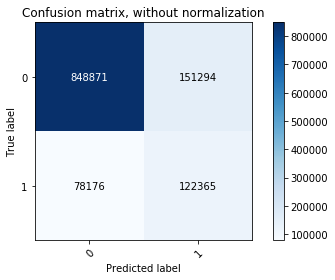

In [35]:
plot_confusion_matrix(testing['DEP_DELAY_BI'],y_pred_mlp,[0,1])

Normalized confusion matrix
[[0.84873096 0.15126904]
 [0.38982552 0.61017448]]


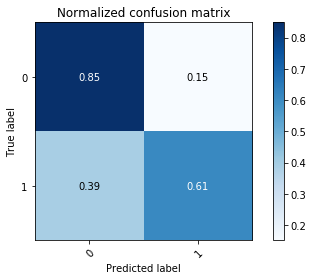

In [36]:
plot_confusion_matrix(testing['DEP_DELAY_BI'],y_pred_mlp,[0,1],normalize=True)

### Fit a baseline without LSTM input

In [19]:
features2 = ['CRS_ELAPSED_TD','CRS_DEP_DT','CRS_ARR_DT','DewPointC','DEP_DELAY_prev','AVG_DELAY6','Month',
             'EST_TRN','OD_DELAY6','MIN5_TRN','Buff_TRN','DISTANCE','cloudcover']
testing_input = testing[features2]

TD_cols = ['CRS_ELAPSED_TD','EST_TRN']
for i in TD_cols:
    testing_input.loc[:,i] = pd.to_timedelta(testing_input.loc[:,i])
    
testing_input.loc[:,'CRS_ELAPSED_TD'] = testing_input.loc[:,'CRS_ELAPSED_TD'].dt.seconds/60
testing_input.loc[:,'EST_TRN'] = testing_input.loc[:,'EST_TRN'].dt.seconds/60
testing_input.loc[:,'CRS_DEP_DT'] = testing_input.loc[:,'CRS_DEP_DT'].dt.hour
testing_input['CRS_ARR_DT'] = pd.to_datetime(testing_input['CRS_ARR_DT'])
testing_input.loc[:,'CRS_ARR_DT'] = testing_input.loc[:,'CRS_ARR_DT'].dt.hour

In [20]:
training_input = training_prev[features2]
training_input.loc[:,'CRS_ELAPSED_TD'] = training_input.loc[:,'CRS_ELAPSED_TD'].dt.seconds/60
training_input.loc[:,'EST_TRN'] = training_input.loc[:,'EST_TRN'].dt.seconds/60
training_input.loc[:,'CRS_DEP_DT'] = training_input.loc[:,'CRS_DEP_DT'].dt.hour
training_input.loc[:,'CRS_ARR_DT'] = training_input.loc[:,'CRS_ARR_DT'].dt.hour

In [21]:
cat_cnt = training_prev['DEP_DELAY_BI'].value_counts()

rus = RandomUnderSampler(sampling_strategy={0:cat_cnt[1],
                                            1:cat_cnt[1]},random_state=42)

X_resampled, y_resampled = rus.fit_resample(training_input, training_prev['DEP_DELAY_BI'])

In [22]:
#clf = DecisionTreeClassifier(random_state=29)
clf = RandomForestClassifier(n_estimators=100,random_state=42,verbose=1,n_jobs=-1)
clf.fit(X_resampled, y_resampled)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=1, warm_start=False)

In [23]:
y_pred_base_nolstm = clf.predict(testing_input)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   13.4s finished


In [24]:
print('Accuracy: ' + str(accuracy_score(y_pred_base_nolstm,testing['DEP_DELAY_BI'])))
print('Recall: '+ str(recall_score(y_pred_base_nolstm,testing['DEP_DELAY_BI'],average='macro')))
print('Precision'+ str(precision_score(y_pred_base_nolstm,testing['DEP_DELAY_BI'],average='macro')))
print('F1 ' + str(f1_score(y_pred_base_nolstm,testing['DEP_DELAY_BI'],average='macro')))

Accuracy: 0.8302373770098592
Recall: 0.7069029284896134
Precision0.7476102506310438
F1 0.723142196538273


Confusion matrix, without normalization
[[871826 128339]
 [ 75496 125045]]


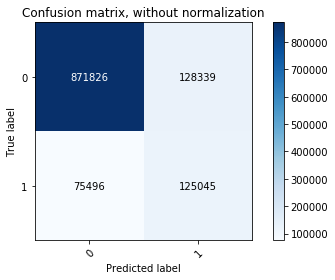

In [44]:
plot_confusion_matrix(testing['DEP_DELAY_BI'],y_pred_base_nolstm,[0,1])

Normalized confusion matrix
[[0.87168217 0.12831783]
 [0.37646167 0.62353833]]


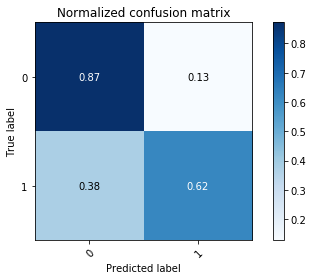

In [45]:
plot_confusion_matrix(testing['DEP_DELAY_BI'],y_pred_base_nolstm,[0,1],normalize=True)

## Build a XGBoost model and CV

### CV model

In [12]:
def cv_folds(x_train,y_train,train_month,feature_names):
    train_ix = x_train[(x_train['Month']<=train_month)
                       &(x_train['Month']>=train_month-1)
                      ].index
    val_ix = x_train[(x_train['Month']>train_month)&(x_train['Month']<=train_month+1)].index
    # keeping validation set apart and undersampling in each iteration 
    train, validation = x_train.iloc[train_ix], x_train.iloc[val_ix]
    target_train, target_val = y_train.iloc[train_ix], y_train.iloc[val_ix]
    # convert to xgboost format
    d_train = xgb.DMatrix(train.values, target_train.values,feature_names=feature_names)
    d_val = xgb.DMatrix(validation.values, target_val.values,feature_names=feature_names)
    train = xgb.DMatrix(train.values,feature_names=feature_names)
    validation = xgb.DMatrix(validation.values,feature_names=feature_names)
    return d_train,d_val,train,validation,target_train,target_val

In [13]:
def xgb_train(x_train,y_train,params,feature_names,
              num_round = 100,early_stopping_rounds=10):
    
    cross_val_f1_score_lst = [];cross_val_accuracy_lst = [];train_accuracy_lst = [];cross_val_recall_lst = []
    cross_val_precision_lst = [];validation_preds_lst = [];target_val_lst = [];cross_val_roc_lst = []
    
    train_end_months = np.array([2,3,4,5,6,7,8])
    for i, train_month in enumerate(train_end_months):
        print('This is the #'+str(i+1)+' fold')
        d_train,d_val,train,validation,target_train,target_val = cv_folds(x_train,y_train,train_month,feature_names)
        # specify validations set to watch performance
        watchlist = [(d_val, 'eval'), (d_train, 'train')]
        # train the model
        mdl = xgb.train(params, d_train, num_round, watchlist, 
                        early_stopping_rounds=early_stopping_rounds,verbose_eval=False)
        # make the prediction
        val_pred = mdl.predict(validation)
        val_pred = np.array(list(map(lambda x: 0 if x<=0.5 else 1,val_pred)))
        train_pred = mdl.predict(train)
        train_pred = np.array(list(map(lambda x: 0 if x<=0.5 else 1,train_pred)))
        
        cross_val_accuracy_lst.append(accuracy_score(target_val, val_pred))
        train_accuracy_lst.append(accuracy_score(target_train, train_pred))
        cross_val_recall_lst.append(recall_score(target_val, val_pred,average='macro'))
        cross_val_precision_lst.append(precision_score(target_val, val_pred,average='macro'))
        cross_val_f1_score_lst.append(f1_score(target_val, val_pred,average='macro'))
        cross_val_roc_lst.append(roc_auc_score(target_val, val_pred))
        validation_preds_lst.append(val_pred)
        target_val_lst.append(target_val)
    
    metric_dict = {'val_acc': np.mean(cross_val_accuracy_lst),'train_acc':np.mean(train_accuracy_lst),
                   'recall': np.mean(cross_val_recall_lst),'precision': np.mean(cross_val_precision_lst),
                   'f1': np.mean(cross_val_f1_score_lst),'roc_auc':np.mean(cross_val_roc_lst)}
    
    print ('Cross validated accuracy: {}'.format(metric_dict['val_acc']))
    print ('Training accuracy: {}'.format(metric_dict['train_acc']))
    print ('Cross validated recall score: {}'.format(metric_dict['recall']))
    print ('Cross validated precision score: {}'.format(metric_dict['precision']))
    print ('Cross validated f1_score: {}'.format(metric_dict['f1']))
    print ('Cross validated roc_auc: {}'.format(metric_dict['roc_auc']))
    
    val_pred = list(chain.from_iterable(validation_preds_lst))
    target_val = list(chain.from_iterable(target_val_lst))
    plot_confusion_matrix(target_val,val_pred,classes=[0,1],normalize=True) #plot confusion matrix
    plot_confusion_matrix(target_val,val_pred,classes=[0,1],normalize=False)
    
    return mdl, metric_dict

In [14]:
scale_pos_weight = training_prev['DEP_DELAY_BI'].value_counts()[0]/training_prev['DEP_DELAY_BI'].value_counts()[1]
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric':'auc',
    'eta': 0.1,
    'scale_pos_weight':scale_pos_weight,
    'nthread':4,
    'max_depth':5,
    'min_child_weight':3,
    'gamma':0,
    'subsample':0.8,
    'colsample_bytree':0.8
    }
num_round = 200
early_stopping_rounds=5

This is the #1 fold
This is the #2 fold
This is the #3 fold
This is the #4 fold
This is the #5 fold
This is the #6 fold
This is the #7 fold
Cross validated accuracy: 0.8188384372354618
Training accuracy: 0.8238459506648015
Cross validated recall score: 0.7653248179823915
Cross validated precision score: 0.717977487452187
Cross validated f1_score: 0.7346995011299458
Cross validated roc_auc: 0.7653248179823916
Normalized confusion matrix
[[0.84689323 0.15310677]
 [0.30786893 0.69213107]]
Confusion matrix, without normalization
[[1814412  328021]
 [ 156741  352375]]


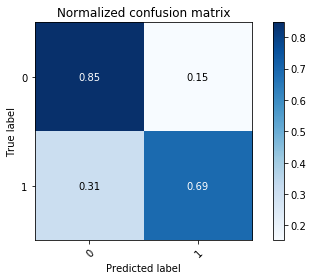

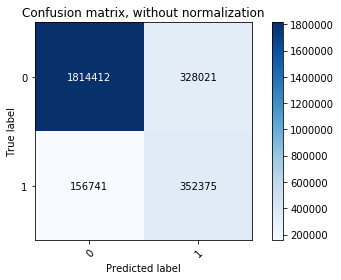

In [27]:
mdl,metric_dict = xgb_train(training_input,training_prev['DEP_DELAY_BI'],
                            params=xgb_params,feature_names=features,
                            num_round = num_round,early_stopping_rounds=early_stopping_rounds)

In [35]:
features = list(reversed(['Airport Delay','Turnaround Slack','Departure Delay previous flight','Scheduled Turnaround','Minimum Turnaround','Avg. Delay last 6 hours',
                    'Distance','Scheduled Departure Time','Scheduled Elapsed Time','Dew Point','Cloud Cover','Scheduled Arrival Time','Temp','Pressure','Humidity',
                    'Wind Speed','OD-pair Delay','Weekday','WN','Precipitation','AA','F9','MQ','DL','Month','B6','AS','OO','YX','EV','UA','OH','HA','YV','NK','G4']))

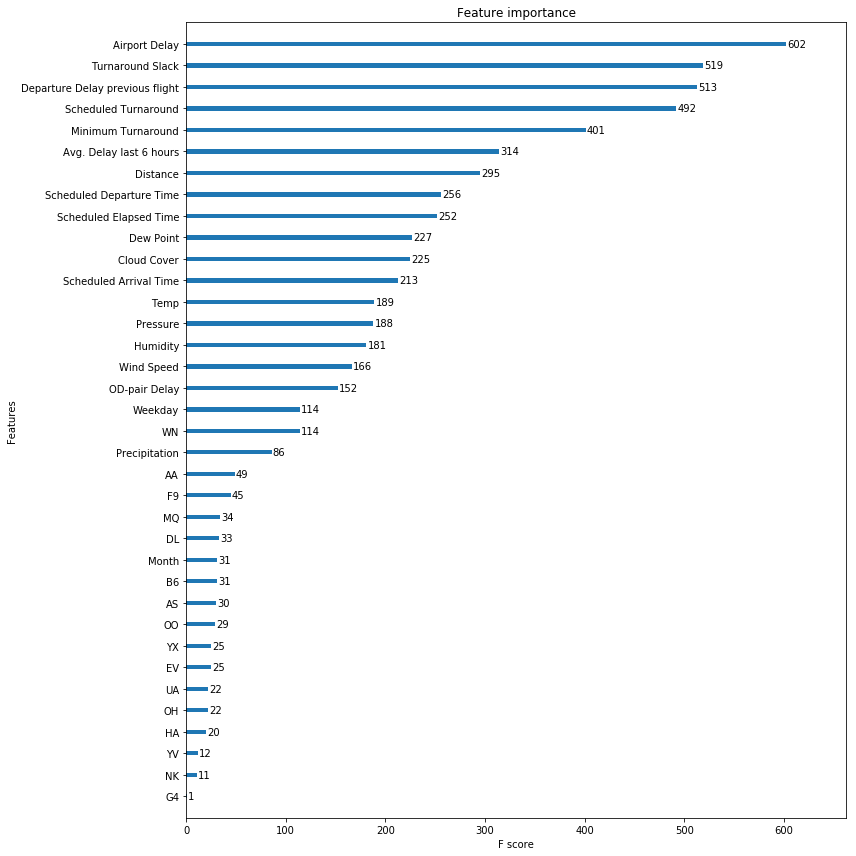

In [48]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
xgb.plot_importance(mdl,ax=ax,grid=False)
ax.set_yticklabels(features)
plt.savefig('./images/fea_impo.png',dpi=600,bbox_inches="tight")
plt.tight_layout()
plt.show()

### Grid Search CV

In [13]:
performance = pd.DataFrame([],columns=['objective', 'eval_metric', 'eta', 'scale_pos_weight', 'nthread',
                                       'max_depth', 'min_child_weight', 'gamma', 'subsample', 'colsample_bytree','reg_alpha',
                                       'num_rounds','early_stopping_rounds', 'val_acc', 'train_acc', 'recall', 'precision',
                                       'f1', 'roc_auc'])

In [105]:
def gs_cv_xgb1(X,Y,lower,upper,interval,target_param,params,
              num_round,early_stopping_rounds,feature_names,performance_df):
    # a for loop to iterate over the possible values for the target parameter
    for i in np.arange(lower,upper+interval,interval):
        params[target_param] = i
        print(target_param + ': ' + str(i))
        # train the model with 7 folds cv
        mdl,metric_dict = xgb_train(X,Y,params=params,feature_names=feature_names,num_round = num_round,
                                    early_stopping_rounds=early_stopping_rounds)
        
        # append the metrics and hyper-parameters to the dataframe
        a_dict = {**params,**{'num_rounds':num_round,'early_stopping_rounds':5},**metric_dict}
        performance_df = performance_df.append(a_dict,ignore_index=True)
    
    return performance_df,mdl

In [57]:
def gs_cv_xgb2(X,Y,target_names,para_values,params,
              num_round,early_stopping_rounds,feature_names,performance_df):
    for i in para_values[0]:
        params[target_names[0]] = i
        for j in para_values[1]:
            params[target_names[1]] = j
            print(str(target_names[0]) + ': ' + str(i) + ' & ' + target_names[1] + ': ' + str(j))
            # train the model with 7 folds cv
            mdl,metric_dict = xgb_train(X,Y,params=params,feature_names=feature_names,num_round = num_round,
                                        early_stopping_rounds=early_stopping_rounds)

            # append the metrics and hyper-parameters to the dataframe
            a_dict = {**params,**{'num_rounds':num_round,'early_stopping_rounds':5},**metric_dict}
            performance_df = performance_df.append(a_dict,ignore_index=True)
    
    return performance_df,mdl

In [112]:
scale_pos_weight = training_prev['DEP_DELAY_BI'].value_counts()[0]/training_prev['DEP_DELAY_BI'].value_counts()[1]
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric':'auc',
    'eta': 0.1,
    'scale_pos_weight':scale_pos_weight,
    'nthread':4,
    'max_depth':5,
    'min_child_weight':3,
    'gamma':0,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'reg_alpha':0
    }
num_round = 150
early_stopping_rounds = 5

In [80]:
X = training_input
Y = training_prev['DEP_DELAY_BI']
X,_1,Y,_2 = train_test_split(X,Y,test_size=0.9,random_state=36, stratify=X['Month'])
X.reset_index(drop=True,inplace=True)
Y.reset_index(drop=True,inplace=True)

In [109]:
performance,mdl = gs_cv_xgb2(X,Y,target_names=['subsample','colsample_bytree'],para_values=[[0.6,0.7,0.8,0.9],[0.6,0.7,0.8,0.9]],
                             params=xgb_params,num_round=num_round,early_stopping_rounds=early_stopping_rounds,
                             feature_names=features,performance_df=performance)

subsample: 0.6 & colsample_bytree: 0.6
This is the #1 fold
This is the #2 fold
This is the #3 fold
This is the #4 fold
This is the #5 fold
This is the #6 fold
This is the #7 fold
This is the #5 fold
This is the #6 fold
This is the #7 fold
Cross validated accuracy: 0.8194194416333109
Training accuracy: 0.8442284196950915
Cross validated recall score: 0.7571012955253212
Cross validated precision score: 0.7172551679772249
Cross validated f1_score: 0.7318662669817273
Cross validated roc_auc: 0.7571012955253212
subsample: 0.7 & colsample_bytree: 0.6
This is the #1 fold
This is the #2 fold
This is the #3 fold
This is the #4 fold
This is the #5 fold
This is the #6 fold
This is the #7 fold
Cross validated accuracy: 0.820629583126413
Training accuracy: 0.8434342591987244
Cross validated recall score: 0.7578035151522801
Cross validated precision score: 0.7186647801124975
Cross validated f1_score: 0.7330865316932188
Cross validated roc_auc: 0.7578035151522802
subsample: 0.7 & colsample_bytree: 0.

In [111]:
performance.sort_values(by='roc_auc',ascending=False)

,objective,eval_metric,eta,scale_pos_weight,nthread,max_depth,min_child_weight,gamma,subsample,colsample_bytree,reg_alpha,num_rounds,early_stopping_rounds,val_acc,train_acc,recall,precision,f1,roc_auc
1,binary:logistic,auc,0.1,4.322689,4,5,3,0,0.8,0.8,0,150,5,0.817240,0.832862,0.759349,0.715862,0.731276,0.759349
43,binary:logistic,auc,0.1,4.322689,4,6,6,0.4,0.8,0.6,0,150,5,0.821445,0.844060,0.759110,0.719843,0.734359,0.759110
26,binary:logistic,auc,0.1,4.322689,4,5,6,0,0.8,0.8,0,150,5,0.817169,0.832133,0.759065,0.715663,0.731064,0.759065
24,binary:logistic,auc,0.1,4.322689,4,5,4,0,0.8,0.8,0,150,5,0.817191,0.832624,0.759035,0.715549,0.731022,0.759035
22,binary:logistic,auc,0.1,4.322689,4,4,5,0,0.8,0.8,0,150,5,0.812681,0.822464,0.759034,0.711528,0.727674,0.759034
21,binary:logistic,auc,0.1,4.322689,4,4,4,0,0.8,0.8,0,150,5,0.812909,0.822415,0.758971,0.711756,0.727825,0.758971
47,binary:logistic,auc,0.1,4.322689,4,6,6,0.4,0.9,0.6,0,150,5,0.822077,0.844197,0.758863,0.720299,0.734632,0.758863
25,binary:logistic,auc,0.1,4.322689,4,5,5,0,0.8,0.8,0,150,5,0.816635,0.832345,0.758843,0.715057,0.730545,0.758843
2,binary:logistic,auc,0.1,4.322689,4,5,5,0,0.8,0.8,0,150,5,0.816635,0.832345,0.758843,0.715057,0.730545,0.758843
44,binary:logistic,auc,0.1,4.322689,4,6,6,0.4,0.8,0.7,0,150,5,0.821928,0.844994,0.758827,0.720090,0.734517,0.758827


## Focus on the ATL airport

In [37]:
ORI_ATL = training_prev[training_prev['ORIGIN'] == 'ATL']
#DEST_ATL = training[training['DEST'] == 'ATL']

In [38]:
print(ORI_ATL.shape)
#print(DEST_ATL.shape)

(277746, 54)


In [39]:
ORI_ATL.columns

Index(['FL_DATE', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN', 'DEST_AIRPORT_ID', 'DEST', 'DEP_DELAY',
       'ARR_DELAY', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME',
       'DISTANCE', 'CRS_DEP_DT', 'DEP_DELAY_TD', 'CRS_ELAPSED_TD', 'DEP_DT',
       'Weekday', 'Month', 'Day', 'Week_no', 'CRS_ARR_DT', 'ARR_DELAY_TD',
       'ARR_DT', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'uvIndex', 'visibility', 'winddir16Point', 'winddirDegree',
       'windspeedKmph', 'weatherDesc_new', 'Wide', 'Year', 'DEST_prev',
       'ARR_DT_prev', 'Turnaround_time', 'DISTANCE_prev', 'DEP_DELAY_prev',
       'DEP_DELAY_CAT', 'Last2', 'Last14', 'Last8', 'AVG_DELAY6',
       'DEP_DELAY_BI'],
      dtype='object')

## Data Visualisation

### Demand Profile

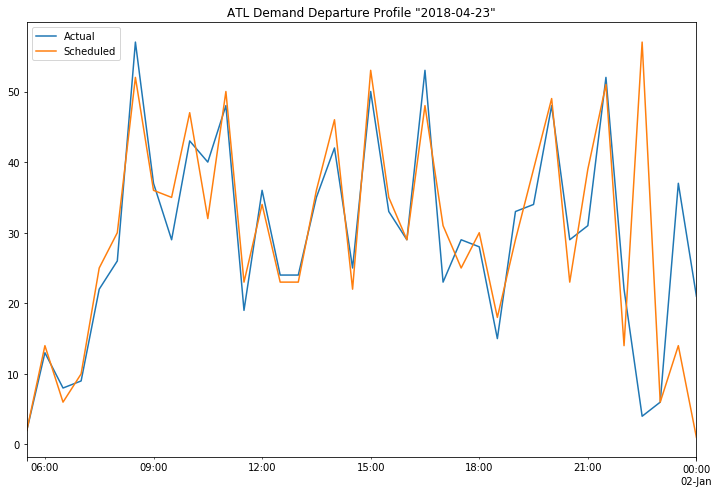

In [15]:
ORI_ATL[ORI_ATL['FL_DATE']=='2018-04-23']['DEP_TIME_HfHr'].value_counts().sort_index()[4:].plot(figsize=(12,8),label='Actual')
ORI_ATL[ORI_ATL['FL_DATE']=='2018-04-23']['CRS_DEP_TIME_HfHr'].value_counts().sort_index().plot(figsize=(12,8),label='Scheduled')
plt.title('ATL Demand Departure Profile "2018-04-23"')
plt.legend()
plt.show()

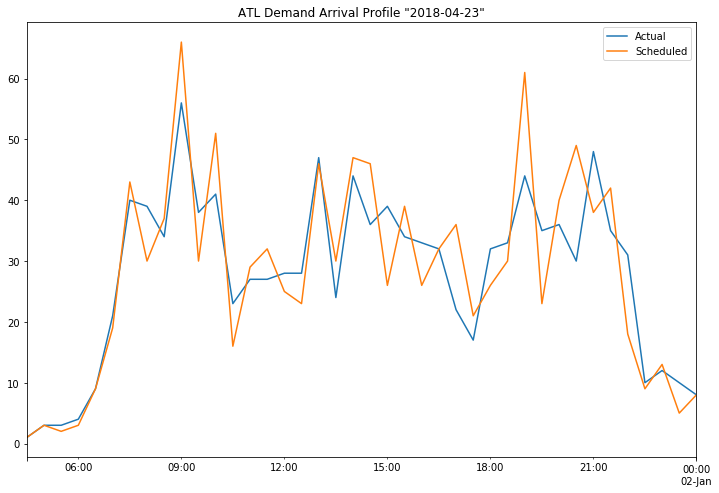

In [14]:
DEST_ATL[DEST_ATL['FL_DATE']=='2018-04-23']['ARR_TIME_HfHr'].value_counts().sort_index()[4:].plot(figsize=(12,8),label='Actual')
DEST_ATL[DEST_ATL['FL_DATE']=='2018-04-23']['CRS_ARR_TIME_HfHr'].value_counts().sort_index()[3:].plot(figsize=(12,8),label='Scheduled')
plt.title('ATL Demand Arrival Profile "2018-04-23"')
plt.legend()
plt.show()

### Average daily departure delay in a year

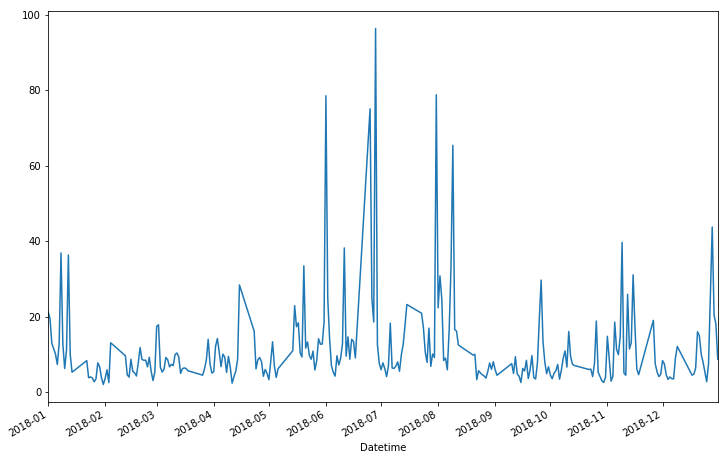

In [16]:
ORI_ATL.groupby(['Datetime']).mean()['DEP_DELAY_NEW'].plot(figsize=(12,8))
plt.show()

### Average hourly departure delay in a day 

In [8]:
training_prev['CRS_DEP_Hr'] = training_prev['CRS_DEP_DT'].dt.hour

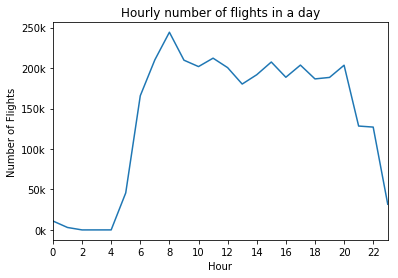

In [20]:
ax = training_prev.groupby(['CRS_DEP_Hr']).size().plot()
plt.xlabel('Hour')
plt.ylabel('Number of Flights')
plt.title('Hourly number of flights in a day')
plt.xticks(np.arange(0,24,2))
ax.set_yticklabels(['','0k','50k','100k','150k','200k','250k'])
plt.savefig("./images/1.png", dpi=300)
plt.show()

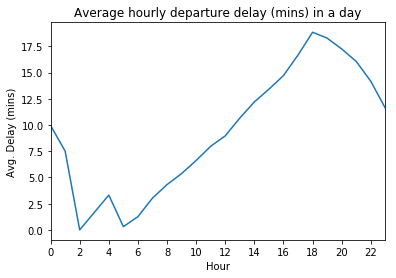

In [11]:
training_prev.groupby(['CRS_DEP_Hr']).mean()['DEP_DELAY'].plot()
plt.xlabel('Hour')
plt.ylabel('Avg. Delay (mins)')
plt.title('Average hourly departure delay (mins) in a day')
plt.xticks(np.arange(0,24,2))
plt.savefig("2.png", dpi=300)
plt.show()

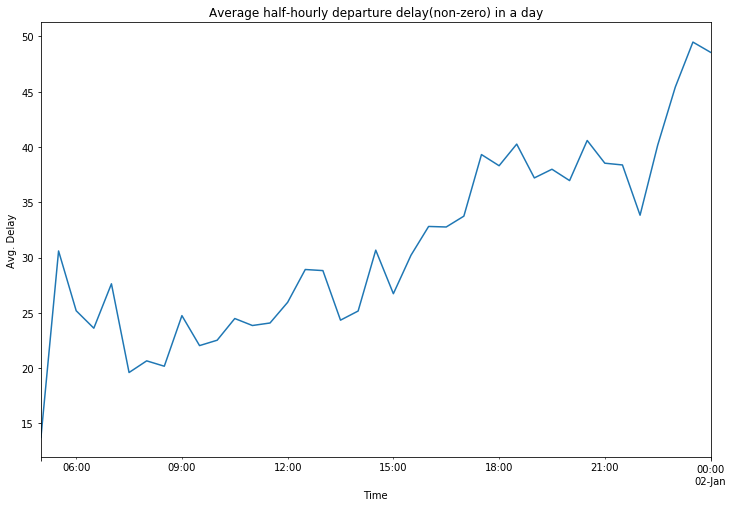

In [17]:
ORI_ATL[ORI_ATL['DEP_DELAY_NEW']>0].groupby(['CRS_DEP_TIME_HfHr']).mean()['DEP_DELAY_NEW'].plot(figsize=(12,8))
plt.xlabel('Time')
plt.ylabel('Avg. Delay')
plt.title('Average half-hourly departure delay(non-zero) in a day')
plt.show()

### Boxplot of departure delay by weekday

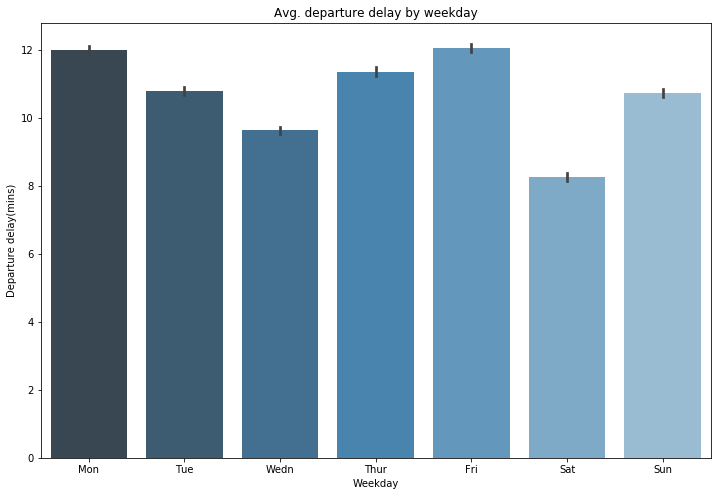

In [32]:
plt.figure(figsize=(12,8))
sns.barplot(x="Weekday", y="DEP_DELAY", data=training_prev, palette="Blues_d")
plt.title('Avg. departure delay by weekday')
plt.ylabel('Departure delay(mins)')
plt.xticks(np.arange(7),('Mon','Tue','Wedn','Thur','Fri','Sat','Sun'))
plt.show()

### Average departure delay by carrier

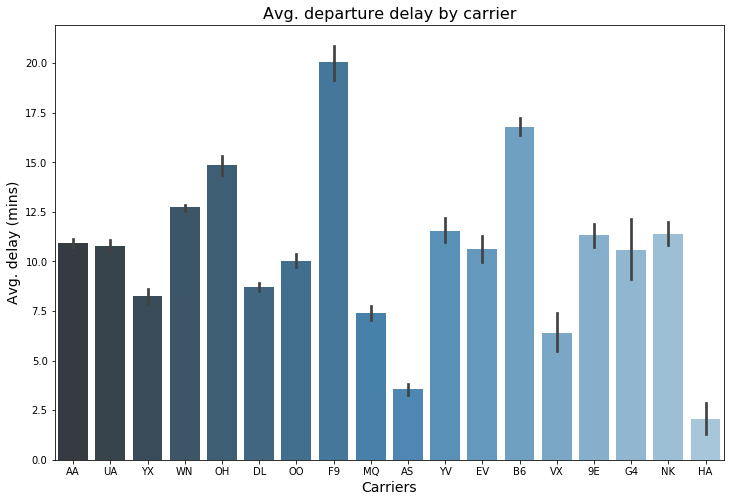

In [9]:
plt.figure(figsize=(12,8))
sns.barplot(x="OP_UNIQUE_CARRIER", y="DEP_DELAY", data=training_prev.sample(frac=0.3),palette="Blues_d")
plt.title('Avg. departure delay by carrier',size=16)
plt.ylabel('Avg. delay (mins)',size=14)
plt.xlabel('Carriers',size=14)
plt.show()

### Avg. departure delay by weather

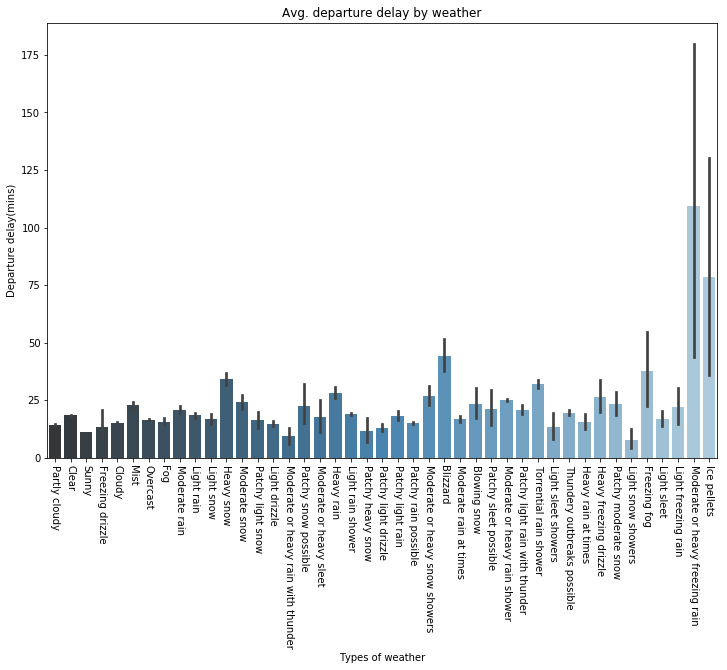

In [117]:
plt.figure(figsize=(12,8))
sns.barplot(x="weatherDesc_new", y="DEP_DELAY", 
            data=training_prev[training_prev['EST_TRN']<=timedelta(seconds=60*60*1)],
            palette="Blues_d")
plt.title('Avg. departure delay by weather')
plt.ylabel('Departure delay(mins)')
plt.xticks(rotation=270)
plt.xlabel('Types of weather')
plt.show()

In [120]:
training_prev['weatherDesc_new'].value_counts()

Sunny                                  1448168
Partly cloudy                           619622
Clear                                   330884
Overcast                                279978
Cloudy                                  204220
Patchy rain possible                    144602
Moderate or heavy rain shower            73841
Light rain shower                        57346
Thundery outbreaks possible              32154
Mist                                     24658
Light drizzle                            17677
Torrential rain shower                   14168
Light rain                               13710
Fog                                      12666
Moderate rain                            11141
Moderate rain at times                    9420
Heavy snow                                7563
Patchy light rain with thunder            7369
Patchy light drizzle                      5630
Patchy light rain                         3779
Light snow                                3691
Moderate snow

### Correlation Matrix

In [16]:
weather = training_prev[['DewPointC', 'cloudcover','humidity', 'precipMM', 'pressure','tempC',
                         'uvIndex', 'visibility','windspeedKmph']]

In [20]:
pd.concat([weather,training_prev['DEP_DELAY']],axis=1).corr().iloc[-1,:-1]

DewPointC        0.043756
cloudcover       0.035107
humidity         0.042071
precipMM         0.058994
pressure        -0.047343
tempC            0.027104
uvIndex          0.009330
visibility      -0.042325
windspeedKmph    0.028446
Name: DEP_DELAY, dtype: float64

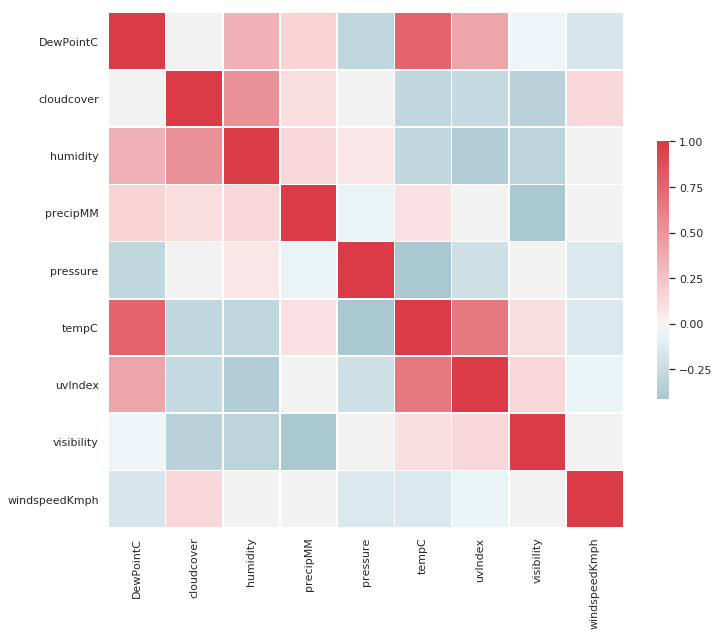

In [17]:
sns.set(style="white")


# Compute the correlation matrix
corr = pd.concat([weather,training_prev['DEP_DELAY']],axis=1).corr()
#corr = weather.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, 
            #vmax=.3, 
            center=0,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5})
plt.tight_layout()
plt.savefig("./images/weather.png", dpi=300)
plt.show()

### Airport Delay last 6 hours

In [21]:
np.percentile(training_prev['AVG_DELAY6'], 5)

-4.036036036036036

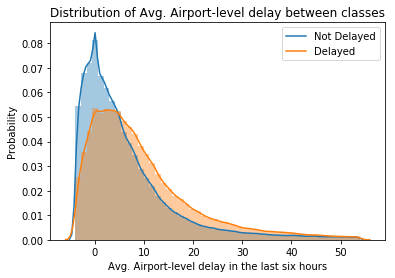

In [68]:
ax1 = sns.distplot(training_prev[(training_prev['DEP_DELAY_BI']==0)&
                                 (training_prev['AVG_DELAY6']<=54)&
                                 (training_prev['AVG_DELAY6']>=-4)]['AVG_DELAY6'],
                  kde_kws={'label':'Not Delayed'})
ax2 = sns.distplot(training_prev[(training_prev['DEP_DELAY_BI']==1)&
                                 (training_prev['AVG_DELAY6']<=54)&
                                 (training_prev['AVG_DELAY6']>=-4)]['AVG_DELAY6'],
                  kde_kws={'label':'Delayed'})
plt.xlabel('Avg. Airport-level delay in the last six hours')
plt.ylabel('Probability')
plt.title('Distribution of Avg. Airport-level delay between classes')
plt.savefig("APR_delay.png", dpi=300)
plt.show()

In [29]:
np.mean(training_prev[(training_prev['DEP_DELAY_BI']==0)]['AVG_DELAY6'])

10.944780765787677

In [30]:
np.mean(training_prev[(training_prev['DEP_DELAY_BI']==1)]['AVG_DELAY6'])

13.257735761672885

In [31]:
np.std(training_prev[(training_prev['DEP_DELAY_BI']==0)]['AVG_DELAY6'])

27.804724784219232

In [32]:
np.std(training_prev[(training_prev['DEP_DELAY_BI']==1)]['AVG_DELAY6'])

24.099913687776343

In [27]:
from scipy import stats
stats.ttest_ind(training_prev[(training_prev['DEP_DELAY_BI']==0)]['AVG_DELAY6'], training_prev[(training_prev['DEP_DELAY_BI']==1)]['AVG_DELAY6'], equal_var = False)

Ttest_indResult(statistic=-66.50307347494329, pvalue=0.0)

### OD-pair

In [37]:
np.percentile(training_prev['OD_DELAY6'], 95)

41.0

In [52]:
pos = training_prev[(training_prev['DEP_DELAY_BI']==1)&(training_prev['OD_DELAY6']!=0)]['OD_DELAY6']
neg = training_prev[(training_prev['DEP_DELAY_BI']==0)&(training_prev['OD_DELAY6']!=0)]['OD_DELAY6']

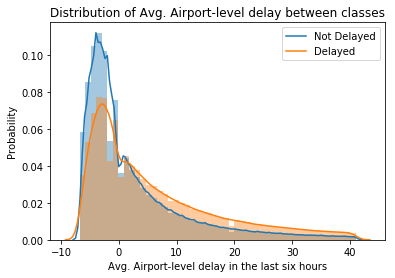

In [55]:
ax1 = sns.distplot(training_prev[(training_prev['DEP_DELAY_BI']==0)&
                                 (training_prev['OD_DELAY6']>=-6.75)&
                                 (training_prev['OD_DELAY6']<=41)&
                                 (training_prev['OD_DELAY6']!=0)]['OD_DELAY6'],
                  kde_kws={'label':'Not Delayed'})
ax2 = sns.distplot(training_prev[(training_prev['DEP_DELAY_BI']==1)&
                                 (training_prev['OD_DELAY6']>=-6.75)&
                                 (training_prev['OD_DELAY6']<=41)&
                                 (training_prev['OD_DELAY6']!=0)]['OD_DELAY6'],
                  kde_kws={'label':'Delayed'})
plt.xlabel('Avg. Airport-level delay in the last six hours')
plt.ylabel('Probability')
plt.title('Distribution of Avg. Airport-level delay between classes')
plt.show()

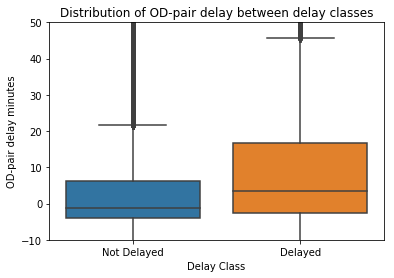

In [67]:
ax = sns.boxplot(x='DEP_DELAY_BI', y='OD_DELAY6',data=training_prev.sample(frac=0.5)[training_prev['OD_DELAY6']!=0])
ax.set_ylim([-10,50])
plt.ylabel('OD-pair delay minutes')
plt.xlabel('Delay Class')
plt.title('Distribution of OD-pair delay between delay classes')
ax.set_xticklabels(['Not Delayed','Delayed'])
plt.savefig("OD.png", dpi=300)
plt.show()

In [39]:
stats.ttest_ind(training_prev[(training_prev['DEP_DELAY_BI']==0)]['OD_DELAY6'], training_prev[(training_prev['DEP_DELAY_BI']==1)]['OD_DELAY6'], equal_var = False)

Ttest_indResult(statistic=-139.19585066308463, pvalue=0.0)

In [40]:
np.mean(training_prev[(training_prev['DEP_DELAY_BI']==0)]['OD_DELAY6'])

5.312760817277513

In [41]:
np.mean(training_prev[(training_prev['DEP_DELAY_BI']==1)]['OD_DELAY6'])

11.529787842803588

### Turnaround Time

In [28]:
sample = training_prev.sample(frac=0.01)
log_delay = np.log(sample['DEP_DELAY']+1-min(sample['DEP_DELAY']))
log_trn = np.log(sample['MIN5_TRN'])

In [54]:
from scipy import stats
stats.ttest_ind(training_prev[(training_prev['DEP_DELAY_BI']==0)]['Buff_TRN'], training_prev[(training_prev['DEP_DELAY_BI']==1)]['Buff_TRN'], equal_var = False)

Ttest_indResult(statistic=-141.92318816195728, pvalue=0.0)

In [55]:
np.mean(training_prev[(training_prev['DEP_DELAY_BI']==0)]['Buff_TRN'])

111.38780139340433

In [56]:
np.mean(training_prev[(training_prev['DEP_DELAY_BI']==1)]['Buff_TRN'])

182.90137413323853

In [57]:
np.std(training_prev[(training_prev['DEP_DELAY_BI']==0)]['Buff_TRN'])

232.2855555276429

In [58]:
np.std(training_prev[(training_prev['DEP_DELAY_BI']==1)]['Buff_TRN'])

383.36872290158107

In [79]:
np.quantile(training_prev['DEP_DELAY'],0.25) - 1.5*(np.quantile(training_prev['DEP_DELAY'],0.75) 
                                                    - np.quantile(training_prev['DEP_DELAY'],0.25))

-24.5

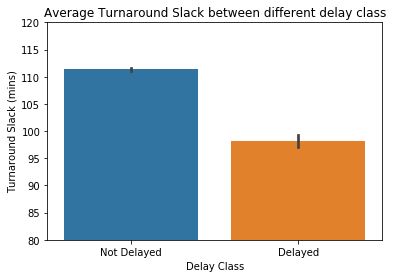

In [84]:
ax = sns.barplot(x='DEP_DELAY_BI',y='Buff_TRN',data=training_prev[(training_prev['DEP_DELAY']<=27.5)&
                                                                  (training_prev['DEP_DELAY']>=-24.5)])
plt.xlabel('Delay Class')
plt.ylabel('Turnaround Slack (mins)')
plt.title('Average Turnaround Slack between different delay class')
ax.set_xticklabels(['Not Delayed','Delayed'])
ax.set_ylim([80,120])
plt.savefig("./images/Buff.png", dpi=300)
plt.show()

### Departure Delay of previous flight

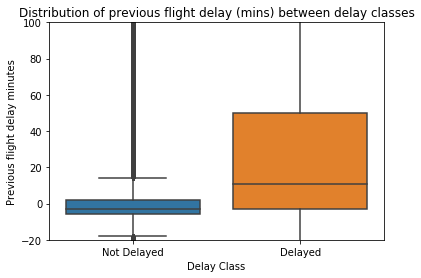

In [106]:
ax = sns.boxplot(x='DEP_DELAY_BI', y='DEP_DELAY_prev',data=training_prev.sample(frac=0.5))
ax.set_ylim([-20,100])
plt.ylabel('Previous flight delay minutes')
plt.xlabel('Delay Class')
plt.title('Distribution of previous flight delay (mins) between delay classes')
ax.set_xticklabels(['Not Delayed','Delayed'])
plt.savefig("./images/prev.png", dpi=300)
plt.show()